In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

说明：对数据的压缩和解压缩算法！—— U-net前身
- 和数据直接相关：压缩与解压缩，**仅仅针对你的输入数据集**！无法做迁移（换别的数据集效果很差）；
- 有损的：压缩过程时有信息丢失的，后面解压缩得到的结果很明显与原图不太一致（细节有缺失）；
- 无监督：输入和输出，都**不需要给标签** —— 整个压缩学习 + 解压学习都自己进行；
- 有监督：要求输出结果（一张图像）尽可能的与输入（一张图像）相近！
- 中间部分是共用的！

过程：
- 压缩部分：把输入的数据（一张图像）压缩为一个向量！
- 解压缩部分：把压缩好的一个向量，恢复成一张图像，该图像和输入数据尽可能一样！

损失函数：
- 输出图像和输入原图之间的差距：例如L2损失

说明：本例用Mnist数据集，用全连接网络。

In [5]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

In [6]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [9]:
# 因为使用全连接，故先把每张图片转为一维的！
x_train = x_train.reshape( x_train.shape[0], -1 )
x_test = x_test.reshape( x_test.shape[0], -1 )
# 看效果：
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [10]:
# 数值归一化：
x_train = tf.cast( x_train, tf.float32 ) / 255
x_test = tf.cast( x_test, tf.float32 ) / 255

In [11]:
input_size = 784
hidden = 32  # 压缩到长度为32停止
output_size = 784

### 1. 模型创建与训练：函数式api自己搭建

In [24]:
input = tf.keras.layers.Input( shape = (input_size,) )  # 注：shape必须是元组，哪怕是一维的

# 压缩encode：2层
en1 = tf.keras.layers.Dense( 64, activation = 'relu', name = 'en1' )(input)
en2 = tf.keras.layers.Dense( hidden, activation = 'relu', name = 'en2' )(en1)

# 解压缩decode：2层
# 说明：de2其实就是输出层：用sigmoid是因为前面像素已经被归一化到[0,1]，sigmoid函数可以把数值映射到这个范围内。
de1 = tf.keras.layers.Dense( 64, activation = 'relu', name = 'de1' )(en2)
de2 = tf.keras.layers.Dense( 784, activation = 'sigmoid', name = 'de2')(de1)  

In [25]:
# 模型创建：
model = tf.keras.Model( inputs = input, outputs = de2 )

In [26]:
# 画图显示：
# tf.keras.utils.plot_model(model, show_shapes = True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [27]:
# 下面编译和训练都是一样的：
model.compile(
    optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001),  # 优化器实例：这里可以自定义一些参数！！！
    loss = 'mse',  # 类似于L2范数
    metrics = ['acc'] 
)

In [31]:
history = model.fit(
    x_train,  # 输入的数据
    x_train,  # “标签”：model输出结果和输入结果x_train要比对
    epochs = 20,
    batch_size = 256,
    shuffle = True,  # 每个epoch都乱序
    validation_data = (x_test, x_test)  # 同样的原理
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0116 - acc: 0.0110 - val_loss: 0.0112 - val_acc: 0.0100
Epoch 2/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0115 - acc: 0.0108 - val_loss: 0.0112 - val_acc: 0.0111
Epoch 3/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0113 - acc: 0.0107 - val_loss: 0.0111 - val_acc: 0.0113
Epoch 4/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0112 - acc: 0.0105 - val_loss: 0.0109 - val_acc: 0.0092
Epoch 5/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0111 - acc: 0.0104 - val_loss: 0.0108 - val_acc: 0.0114
Epoch 6/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0111 - acc: 0.0106 - val_loss: 0.0107 - val_acc: 0.0098
Epoch 7/20
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0110 - acc: 0.0106 - val_loss: 0.

### 2. 模型的预测：

说明：模型的使用，一般**单独**使用它的“编码器”或单独使用它的“解码器”—— 去干类似的别的任务！

Text(0.5, 1.0, '解压缩后图像')

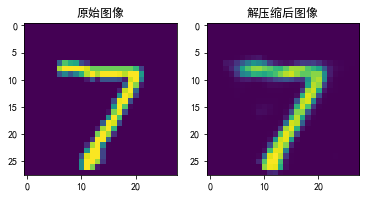

In [61]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

cs = model.predict( tf.reshape(x_test[0], shape = (1,784)) )  # 还是要有“批次”维度的；predict返回一个numpy值！
cs = cs.reshape(28,28)

plt.subplot(1,2,1)
plt.imshow( x_test[0].numpy().reshape(28,28) )
plt.title('原始图像')
plt.subplot(1,2,2)
plt.imshow( cs )
plt.title('解压缩后图像')

In [59]:
x_test[0]

<tf.Tensor: id=36774, shape=(784,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
    

### 3. 提取编码器和解码器：

In [62]:
# 编码器：就是网络的前半部分
encode = tf.keras.Model( inputs = input, outputs = en2 )

In [64]:
# 解码器：就是网络的后半部分
# 先查看当前网络有哪些层：最后2层都要用
model.layers

In [65]:
input_decode = tf.keras.layers.Input( shape = (hidden,) )
decode1 = model.layers[-2](input_decode)
decode2 = model.layers[-1](decode1)
decode = tf.keras.Model( inputs = input_decode, outputs = decode2 )  # 都用的原始模式，训练好的参数不变！

In [66]:
# 对x_test所有图像进行压缩：
encode_test = encode( x_test )

In [72]:
# 对所有获得的压缩数据进行解压缩：
decode_test = decode.predict( encode_test )
decode_test = decode_test.reshape(10000,28,28)

In [73]:
type(encode_test)

tensorflow.python.framework.ops.EagerTensor

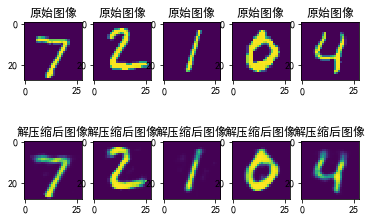

In [77]:
# 画图：5张垂向对比
n = 5
for x in range(n):
    plt.subplot(2, n, x + 1)
    plt.imshow( x_test[x].numpy().reshape(28,28) )
    plt.title('原始图像')
    plt.subplot(2, n, x + n + 1)
    plt.imshow( decode_test[x] )
    plt.title('解压缩后图像')